# <span style="color:#cc6699">  Toxic Spans Detection </span>

<span style="color:#cc6699"> SemEval competition</span>

## Libraries

In [1]:
#library to check if all is run good in for_loop
from tqdm.notebook import tqdm

from ast import literal_eval

import json

# Data manipulation/analysis
import numpy as np
import pandas as pd
import pickle


# Setting random seed
seed = 123

# Data partitioning
from sklearn.model_selection import train_test_split

# Text preprocessing/analysis
import re
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import spacy
import en_core_web_sm

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.feature_extraction import DictVectorizer
from sklearn import neighbors
from sklearn import linear_model #for logistic regression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from itertools import chain

from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

#seeds
from numpy.random import seed
seed(1)
# tensorflow.random.set_random_seed(1)

Using TensorFlow backend.


## Dataset

In [2]:
# Datasets Loading

# training data
dataset = pd.read_csv("data/tsd_train.csv")
# development and validation data
tsd = pd.read_csv("data/tsd_trial.csv") 

Example: "This is a stupid example, so thank you for nothing a!@#!@."

It comprises two toxic spans, <span style="color:Red"> "stupid"</span> and <span style="color:Blue">"a!@#!@"</span>, which have character offsets from 10 to 15 (counting starts from 0) and from 51 to 56 respectively. Systems are then expected to return the following list for this text:

[<span style="color:Red"> 10,11,12,13,14,15,</span> <span style="color:Blue"> 51,52,53,54,55,56</span>]

In [3]:
# if we load a cell that it has list, it will need to
# build the list,otherwise it read as series of characters
dataset.spans = dataset.spans.apply(literal_eval)
dataset.head(1)

,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...


In [4]:
# if we load a cell that it has list, it will need to
# build the list,otherwise it read as series of characters
tsd.spans = tsd.spans.apply(literal_eval)
tsd.head(1)

,spans,text
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...


# Exploratory text analysis 

In [5]:
# check if we have null data to remove-dropna
dataset.isnull().sum()

spans    0
text     0
dtype: int64

In [6]:
# extract the the toxic word from training set

all_bad_word = []
for text in range(0,len(dataset['text'])):
    count = 0 #count how many potition are continuous
    
    bad_word = []
    for i in range(0, len(dataset.spans[text])):
        bad_word.append(dataset.text[text][dataset.spans[text][i]])
    all_bad_word.append(''.join(bad_word))

We can observe that we have concat word without space, for instanse, 'honkeyidiotsdimwitted' = 'honky idiots dimwitted'. Futhermore, we have f**k = fuck and sentences with bad meaning only if we can see as sentence 'three black men in America is a felon'

In [ ]:
# find all Punctuation in words  
import string 

for sentence in all_bad_word: 
    for i in sentence: 
        # checking whether the char is punctuation. 
        if i in string.punctuation: 
          
            # Printing the punctuation values  
            print("Punctuation: " + sentence) 

We can see that punctuation like `*`, `---repeat`, `/`, `$` and `'someting'` play key role, the others are in sentence:

For instance:
`s%#cks`-> keep secret the toxic word

`foola$$ `-> keep secret the toxic word

`fu/kis`-> keep secret the toxic word

`idiotF-----g` -> keep secret the toxic word

`f*** you` -> keep secret the toxic word

`'cool'` -> reveal ironic

We observe the repeat punctuation hide toxic words

Moreover, we can see that hastags hide text(eg `#yourwhitetearsarentsacredthislandis`)

In [9]:
count_non_toxic = 0
for element in all_bad_word:
    if element == '' :
        count_non_toxic +=1
        
print('How many text not have toxic words: ' + str(count_non_toxic))

How many text not have toxic words: 485


from https://towardsdatascience.com/exploratory-text-analysis-in-python-8cf42b758d9e

In [10]:
# Prepare training corpus into one giant string
train_string = " ".join(dataset.text)
print(f"***** Extract of a train string ***** \n{train_string[:200]}", "\n")

***** Extract of a train string ***** 
Another violent and aggressive immigrant killing a innocent and intelligent US Citizen.... Sarcasm I am 56 years old, I am not your fucking junior pal. What you are saying makes no sense. I don't know 



In [11]:
# Split train_corpus by white space
splits = train_string.split()  
print(f"***** Extract of splits ***** \n{splits[:20]}\n")

***** Extract of splits ***** 
['Another', 'violent', 'and', 'aggressive', 'immigrant', 'killing', 'a', 'innocent', 'and', 'intelligent', 'US', 'Citizen....', 'Sarcasm', 'I', 'am', '56', 'years', 'old,', 'I', 'am']



In [12]:
print(f"Number of strings: {len(splits)}")
print(f"Number of unique strings: {len(set(splits))}")

Number of strings: 285388
Number of unique strings: 39593


There are approximately 300.000 strings in the training corpus with around 40.000 unique strings. 

In [13]:
#frequency distribution for each string
freq_splits = FreqDist(splits)
print(f"***** 10 most common strings ***** \n{freq_splits.most_common(10)}", "\n")

***** 10 most common strings ***** 
[('the', 11379), ('to', 7269), ('and', 6555), ('a', 6545), ('of', 5548), ('is', 4943), ('you', 3328), ('in', 3263), ('that', 3207), ('are', 2852)] 



It is obvious that the most common strings are stop words

In [ ]:
# we find all the words that they have less than 4 characters (small words)
short = set(s for s in splits if len(s)<4)
short = [(s, freq_splits[s]) for s in short]
short.sort(key=lambda x:x[1], reverse=True)
short

Many short strings appear to be stop words (like `or`) but there are also numbers(like `2`) and other short words(like `ass`).

Because we haven’t tokenised yet, some strings currently contain punctuation that is attached to a word (like `it.` or `"I`). As a result, otherwise same words are considered as different like `it`,`It`, `it?`, `it.`. Τhey probably need to normalize.

There are numbers in different forms like `('70s', 2)`,`('97%', 2)`,`('1.6', 2)` and `('$2', 2),`. Τhey probably do not need in our case, because a number is not toxic word.

In [ ]:
# we find all the words that they have more than 15 characters (longest words)
long = set(s for s in splits if len(s)>15)
long = [(s, freq_splits[s]) for s in long]
long.sort(key=lambda x:x[1], reverse=True)
long

The frequency of long string looks much lower than short strings. 

For instance `('the', 11379)` vs `('responsibilities', 3)`

There are hyphenated words: `Socio-Communists`, `we-are-shareholders`, `non-contributors` and `discrimination--except`(this one with double hyphens). If we tokenise on white space or punctuation, these strings will be split into separate words. For most cases, this will conserve the gist of the sentence. If we keep hyphenated words as they are, they won’t be as common and consequently removed as rare words.

There are websites like: `https://www.youtube.com/watch?v=bi2QKY3zW8Q`

(Extra: we do not have emails and the `@` not means email)

There are outlaw words that repeats the same character more than twice: `MOOOOOOOOOOOOOOOOOOOOOOooooooooooooooooooooooooooooo...`, `sucks!!........Hmmmm`, `HAAHAHAHAHHAAHHAHAHHAH`, `Waipahoooooooooo????` and  `succcccccccccccccckkkkkk`. If you know the correct term for these elongated words, I would love to find out. Until then, we will refer them as ‘outlaw words’. These outlaw cases seem to appear very rarely.

In [16]:
#from https://stackoverflow.com/questions/42329766/python-nlp-british-english-vs-american-english

# method that convert the British to American English
def replace_all(text, mydict):
    for gb, us in mydict.items():
        text = text.replace(us, gb)
    return text

BvsA = json.load(open("myDict\BritishVSAmerican.txt"))

In [17]:
us_text = replace_all(train_string, BvsA)

In [18]:
# Check if we have NLP British English and American English
if train_string == us_text:
    print(" equals " )
else:
    print( " Not equal, so we have British English and American English.\n"+
           " As a result, we may keep the American form (convert British to American English).")

 Not equal, so we have British English and American English.
 As a result, we may keep the American form (convert British to American English).


If we decide to keep the covert edition, it will need to change the positions of `spans`.

In [19]:
def summarise(pattern, strings, freq):
    """Summarise strings matching a pattern."""
    # Find matches
    compiled_pattern = re.compile(pattern)
    matches = [s for s in strings if compiled_pattern.search(s)]
    
    # Print volume and proportion of matches
    print("{} strings, that is {:.2%} of total".format(len(matches), len(matches)/ len(strings)))
    
    # Create list of tuples containing matches and their frequency
    output = [(s, freq[s]) for s in set(matches)]
    output.sort(key=lambda x:x[1], reverse=True)
    
    return output

In [ ]:
# count the frequent of numbers
summarise(r"\d", splits, freq_splits)

It is frequent to have numbers (54%)

We have a variety of numbers, percentage, numeric, money, date and others. But the numbers, as we said before, do not reveal toxicity. We may need to drop numbers when tokenising. 

In [ ]:
# find the frequent of hyphenated words
summarise(r"\w+-+\w+", splits, freq_splits)

It is frequent (44%), these ones definitely need to be separated.

From glancing through the hyphenated words, it makes more sense to separate them out to keep the data simple. For example: We should tokenise ‘same-sex’ to 2 tokens: `[‘same’, ‘sex’]` instead of 1 token: `[‘same-sex’]`. 

In [ ]:
#count requent of words combined by other punctuation
summarise(r"\w+[_!&/)(<\|}{\[\]]\w+", splits, freq_splits)

Not too frequent, but it is important.

We can observe that some toxic word hidden behind the punctuation. 

For instance, `'(D)onkeys'`->`'Donkeys'`, `fu/k`->`fuck`

Furthermore, we have same similars words, which it seems to be unuseful, like `is/was`,`he/she` or `'him/her'`. In addition, we have same words in different series, like `is/was` and `was/is`

In [ ]:
# count frequent of outlaw words
def find_outlaw(word):
    """Find words that contain a same character 3+ times in a row."""
    is_outlaw = False
    for i, letter in enumerate(word):
        if i > 1:
            if word[i] == word[i-1] == word[i-2] and word[i].isalpha():
                is_outlaw = True
                break
    return is_outlaw

outlaws = [s for s in splits if find_outlaw(s)]
print("{} strings, that is {:.2%} of total".format(len(outlaws), len(outlaws)/ len(splits)))
outlaw_freq = [(s, freq_splits[s]) for s in set(outlaws)]
outlaw_freq.sort(key=lambda x:x[1], reverse=True)
outlaw_freq

Not too frequent, these may not worth correcting for because there too few cases. However, we will need to seperate, because it hidde toxic words like `killls`

In [24]:
# tokenise the text into alphabetic tokens
tokeniser = RegexpTokenizer("[A-Za-z]+")
tokens = tokeniser.tokenize(train_string)
print(tokens[:20], "\n")

['Another', 'violent', 'and', 'aggressive', 'immigrant', 'killing', 'a', 'innocent', 'and', 'intelligent', 'US', 'Citizen', 'Sarcasm', 'I', 'am', 'years', 'old', 'I', 'am', 'not'] 



In [25]:
print(f"Number of tokens: {len(tokens)}")
print(f"Number of unique tokens: {len(set(tokens))}")

Number of tokens: 291899
Number of unique tokens: 22709


There are 300.000 tokens in the training data with around 23.000 unique tokens.

In [26]:
# convert all tokens into lowercase and lemmatise them
lemmatiser = WordNetLemmatizer()
tokens_norm = [lemmatiser.lemmatize(t.lower(), "v") for t in tokens]
print(f"Number of unique tokens: {len(set(tokens_norm))}")

Number of unique tokens: 15220


In [27]:
temp = round(1 - len(set(tokens_norm))/len(set(tokens)), 2)
print('We drop by about ' + str(temp* 100) + '%')

We drop by about 33.0%


**!caution! If we keep the lemmatise method, we should change the `spans`**

In [28]:
# Create list of token lengths for each token
token_length = [len(t) for t in tokens]

# Average number of characters per token
print(f"Average number of characters per token: {round(np.mean(token_length),4)}")

Average number of characters per token: 4.3684


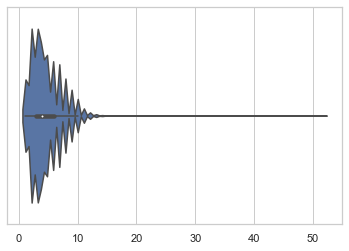

In [29]:
sns.set(style="whitegrid")
ax = sns.violinplot(token_length)

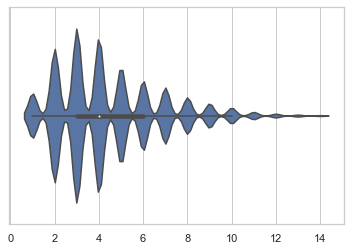

In [30]:
token_length_2 = [len(t) for t in tokens if len(t)<15]

sns.set(style="whitegrid")
ax = sns.violinplot(token_length_2)

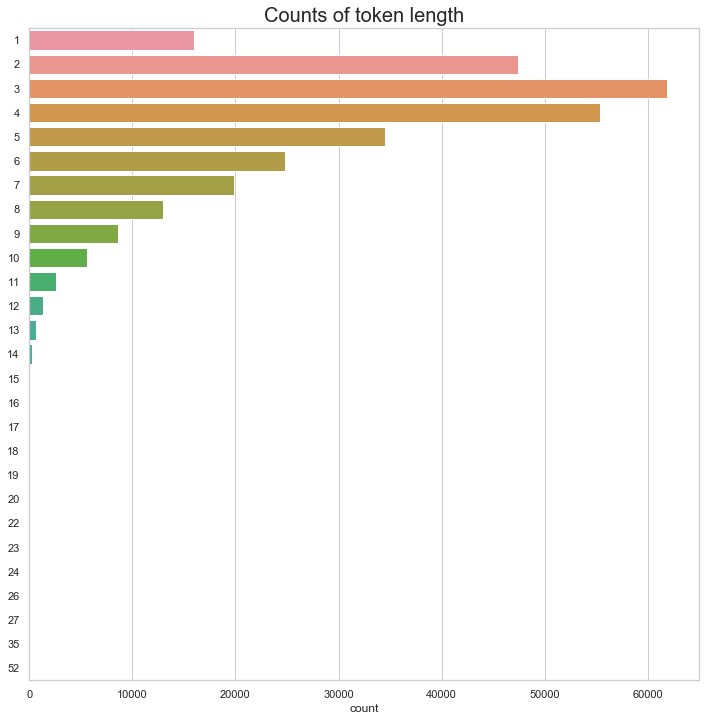

In [31]:
# Plot distribution
plt.figure(figsize=(12, 12))
sns.countplot(y=token_length)
plt.title("Counts of token length", size=20);

There are a few tokens that is very long but also very rare.

In [32]:
# load stopwords and add some more
stop_words = stopwords.words("english")
stop_words.extend(["cannot", "could", "done", "let", "may" "mayn",  "might", "must", "need", "ought", "oughtn", "shall", "would", "br"])

In [33]:
# the most common stop words in our corpus
freq_stopwords = [(sw, tokens_norm.count(sw)) for sw in stop_words]
freq_stopwords.sort(key=lambda x: x[1], reverse=True)
freq_stopwords[:10]

[('be', 12807),
 ('the', 12707),
 ('to', 7440),
 ('and', 7298),
 ('a', 6903),
 ('of', 5669),
 ('you', 5070),
 ('that', 3895),
 ('in', 3507),
 ('it', 3247)]

In [34]:
# count all the stopwords
n_stopwords = len([t for t in tokens_norm if t in stop_words])
print(f"{n_stopwords} tokens are stop words.")
print(f"The proportion of tokens are stop words is: {round(100*n_stopwords/len(tokens_norm),2)}%.")

146177 tokens are stop words.
The proportion of tokens are stop words is: 50.08%.


About half of the tokens are stop words

In [35]:
# remove stop words
tokens_clean = [t for t in tokens_norm if t not in stop_words]
print(f"Number of tokens: {len(tokens_clean)}")

Number of tokens: 145722


In [36]:
def preprocess_text(text):
    """Preprocess text into normalised tokens."""
    # Tokenise words into alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]{2,}')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stop_words]
    return keywords

def get_frequent_ngram(corpus, ngram, n=20):
    """Find most common n n-grams tokens."""
    # Preprocess each document
    documents = [preprocess_text(document) for document in corpus]
    
    # Find ngrams per document
    n_grams = [list(ngrams(document, ngram)) for document in documents]
    
    # Find frequency of ngrams
    n_grams_flattened = [item for sublist in n_grams for item in sublist]
    freq_dist = FreqDist(n_grams_flattened)
    top_freq = freq_dist.most_common(n)
    return pd.DataFrame(top_freq, columns=["ngram", "count"])

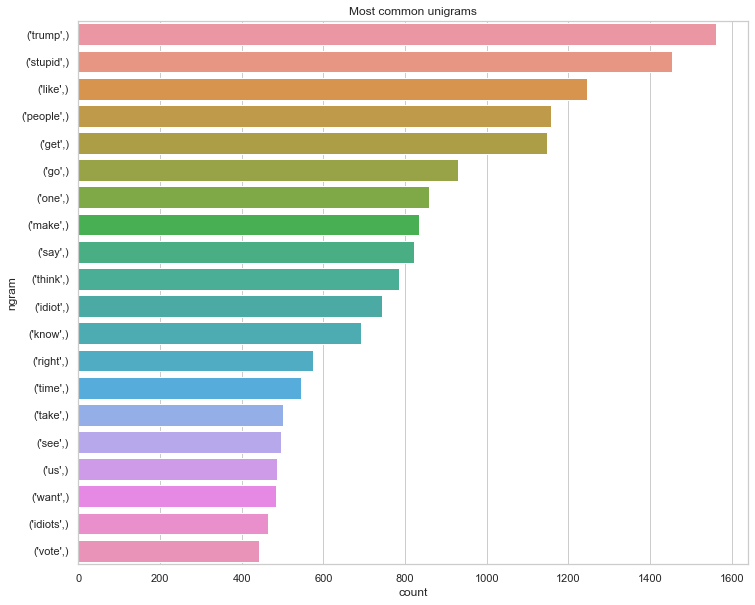

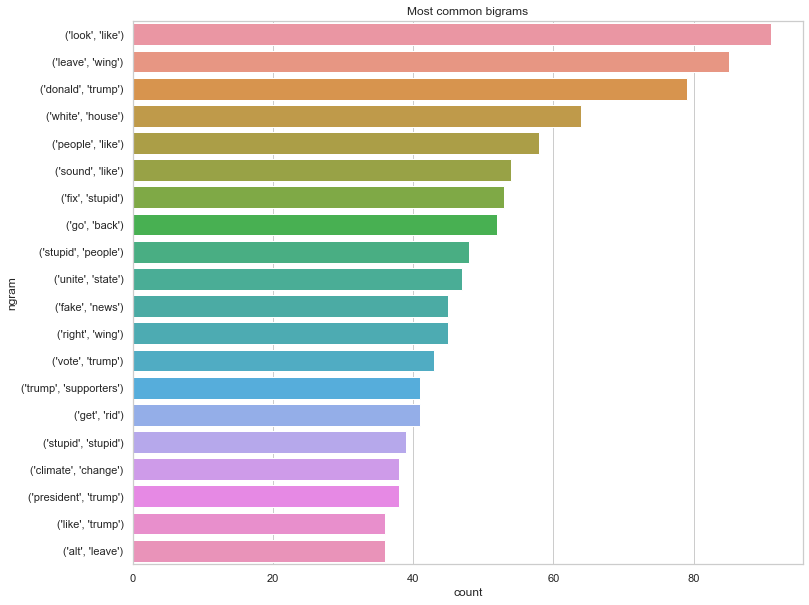

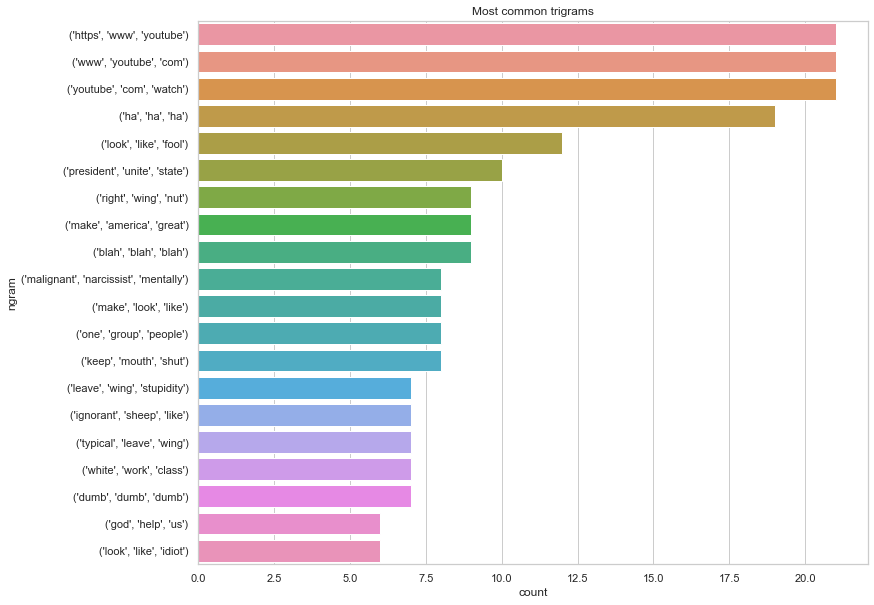

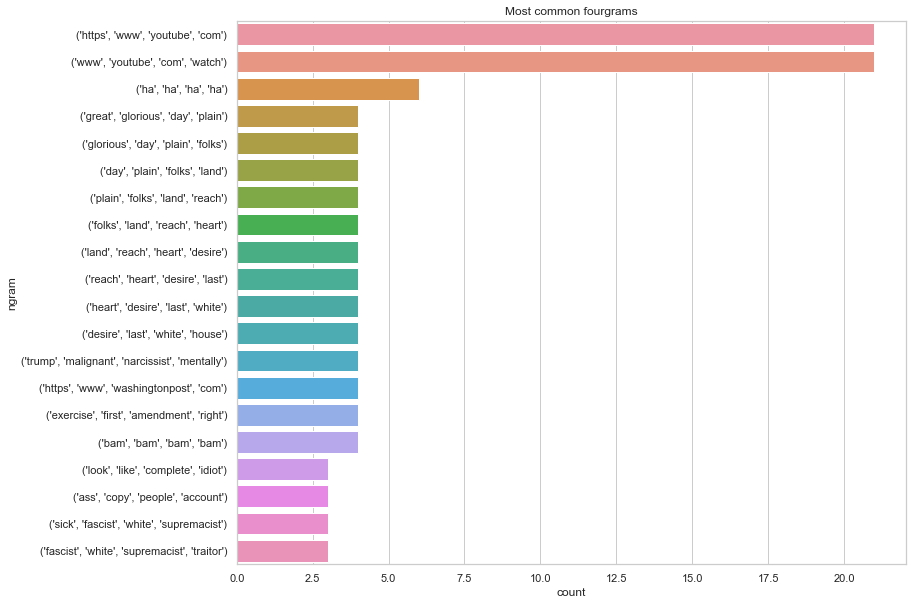

In [37]:
# Get frequent ngrams for all 4
for i in range(1,5):
    mapping = {1:"uni", 2:"bi", 3:"tri", 4:"four"}
    plt.figure(figsize=(12,10))
    sns.barplot(x="count", y="ngram", data=get_frequent_ngram(dataset['text'], i))
    plt.title(f"Most common {mapping[i]}grams");

The word `trump` (logically from `trumpet` after lemm)and `stupid` looks quite frequent compared to the other frequent words.

In [38]:
def get_avg_word_len(x):
    words = x.split()
    word_len = 0
    for word in words:
        word_len = word_len + len(word)
        
    return word_len/len(words)


In [39]:
from nltk.tokenize import word_tokenize
# tokeniser = RegexpTokenizer("[A-Za-z]+")
new_dataset = dataset.copy()

#delete the  None (NA) types in your DF
new_dataset.dropna(inplace=True)

new_dataset["n_sentences"] = new_dataset["text"].apply(sent_tokenize).apply(len)
new_dataset["tokens"] = new_dataset["text"].apply(tokeniser.tokenize)
new_dataset["n_tokens"] = new_dataset["tokens"].apply(len)
new_dataset["n_characters"] = dataset["text"].apply(len)
new_dataset["n_stopwords"] = new_dataset["tokens"].apply(lambda tokens: len([t for t in tokens if t in stop_words]))
new_dataset["p_stopwords"] = new_dataset["n_stopwords"]/new_dataset["n_tokens"]

# Inspect head
new_dataset.head()

,spans,text,n_sentences,tokens,n_tokens,n_characters,n_stopwords,p_stopwords
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...,1,"[Another, violent, and, aggressive, immigrant,...",13,98,3,0.230769
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio...",9,"[I, am, years, old, I, am, not, your, fucking,...",133,695,56,0.421053
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed.",2,"[Damn, a, whole, family, Sad, indeed]",6,33,1,0.166667
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...,3,"[What, a, knucklehead, How, can, anyone, not, ...",12,69,6,0.500000
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA...",15,"[who, do, you, think, should, do, the, killing...",174,960,79,0.454023


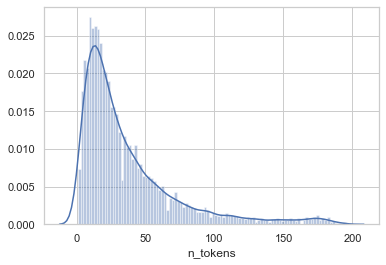

In [40]:
sns.distplot(new_dataset['n_tokens'],bins=100)

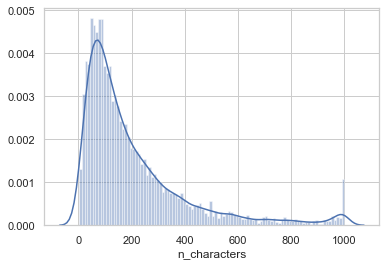

In [41]:
sns.distplot(new_dataset['n_characters'],bins=100)

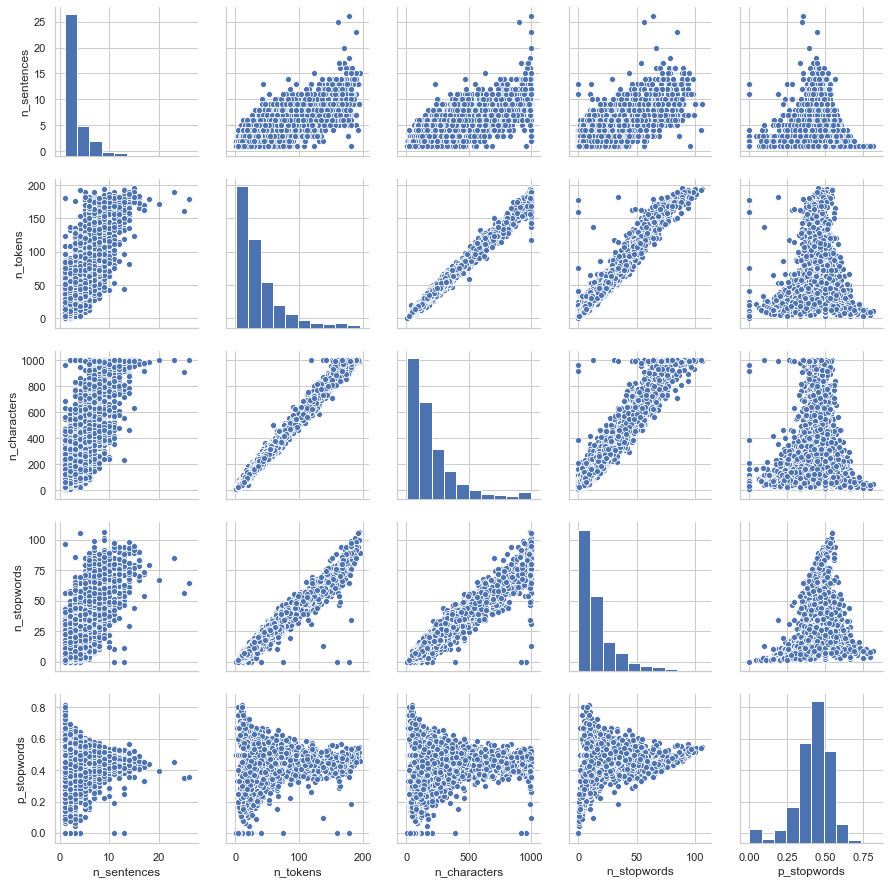

In [42]:
sns.pairplot(new_dataset)

In [43]:
new_dataset.describe()

,n_sentences,n_tokens,n_characters,n_stopwords,p_stopwords
count,7939.000000,7939.000000,7939.000000,7939.000000,7939.000000
mean,2.889533,36.767729,204.570601,16.347021,0.414954
std,2.336196,35.716691,201.369223,16.803066,0.124641
min,1.000000,1.000000,4.000000,0.000000,0.000000
25%,1.000000,13.000000,72.000000,5.000000,0.363636
50%,2.000000,25.000000,136.000000,11.000000,0.434783
75%,4.000000,47.000000,262.000000,21.000000,0.500000
max,26.000000,195.000000,1000.000000,106.000000,0.818182


In [44]:
bad_word_train = pd.DataFrame(all_bad_word, columns = ['toxic'])
bad_word_train

,toxic
0,violent and aggressive immigrant
1,fucking
2,Damn
3,knucklehead
4,killing
...,...
7934,fool
7935,No Blacks Allowed
7936,Any faith that can't stand up to logic and rea...
7937,idiotic


In [45]:
#delete the  None (NA) types in your DF
bad_word_train.replace("",float("NaN") , inplace=True)
bad_word_train = bad_word_train.dropna()

bad_word_train

,toxic
0,violent and aggressive immigrant
1,fucking
2,Damn
3,knucklehead
4,killing
...,...
7934,fool
7935,No Blacks Allowed
7936,Any faith that can't stand up to logic and rea...
7937,idiotic


In [46]:
temp = ' '.join(bad_word_train.toxic.tolist())
bad_word_train_clean = preprocess_text(temp) #call the function

In [47]:
# freguent of toxic words in corpus
bad_word_train_freq = FreqDist(bad_word_train_clean)

In [48]:
# keep the 50 most common words
common_bad_word_train_freq = bad_word_train_freq.most_common(50)

In [49]:
#FreqDist to Pandas dataframe
df_bad_word_train_freq= pd.DataFrame(common_bad_word_train_freq, 
                                    columns = ['Term','Frequency'])
df_bad_word_train_freq.head()

,Term,Frequency
0,stupid,792
1,idiot,505
2,idiots,287
3,fool,186
4,stupidity,177


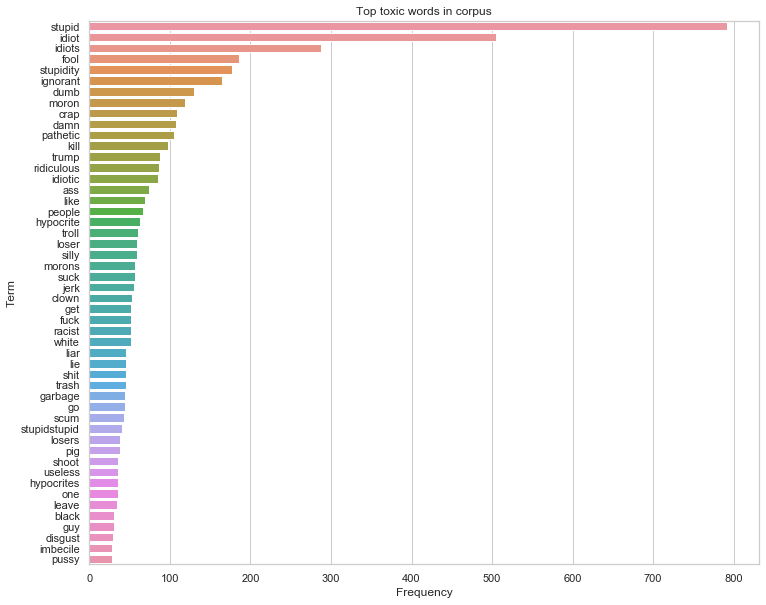

In [50]:
plt.figure(figsize=(12,10))
sns.barplot(x="Frequency", y="Term", data=df_bad_word_train_freq)
plt.title("Top toxic words in corpus");

# Ιnformation Extraction

In [51]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

In [52]:
def tranform_dataset(dataset):
    list_doc = [] # is the number of each row in dataset
    list_tokens = [] # token of each text
    list_span_start = [] # start position of token
    list_span_label = [] # label initialize

    # tranform the dataset as text to token
    for text_i in tqdm(range(0,len(dataset['text']))):

        list_doc.append(text_i)
        
        # tokenization by space " "
        token = dataset.text[text_i].split()
        list_tokens.append(token)

        # code to find the start position of each word
        start_pos = []
        count = 0
        for i in token:
            start_pos.append(count)
            count+=len(i)+1
        list_span_start.append(start_pos)
        
        list_span_label.append([0]* len(start_pos))
        
    
    # add the new list into a dataframe
    df_token = pd.DataFrame(list_doc, columns=['doc'])
    df_token['token'] = list_tokens
    df_token['span_start'] = list_span_start
    
    df_token['toxic'] = list_span_label
    
    return df_token

In [53]:
df_token = tranform_dataset(dataset)

In [54]:
dataset

,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA..."
...,...,...
7934,"[8, 9, 10, 11]",Another fool pipes in.
7935,"[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5...",So if a restaurant owner puts up a sign saying...
7936,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Any faith that can't stand up to logic and rea...
7937,"[5, 6, 7, 8, 9, 10, 11]",This idiotic. Use the surplus to pay down the ...


In [55]:
df_token

,doc,token,span_start,toxic
0,0,"[Another, violent, and, aggressive, immigrant,...","[0, 8, 16, 20, 31, 41, 49, 51, 60, 64, 76, 79,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,"[I, am, 56, years, old,, I, am, not, your, fuc...","[0, 2, 5, 8, 14, 19, 21, 24, 28, 33, 41, 48, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[Damn,, a, whole, family., Sad, indeed.]","[0, 6, 8, 14, 22, 26]","[0, 0, 0, 0, 0, 0]"
3,3,"[What, a, knucklehead., How, can, anyone, not,...","[0, 5, 7, 20, 24, 28, 35, 39, 44, 49, 55, 58]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,"[""who, do, you, think, should, do, the, killin...","[0, 5, 8, 12, 18, 25, 28, 32, 42, 49, 53, 63, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
7934,7934,"[Another, fool, pipes, in.]","[0, 8, 13, 19]","[0, 0, 0, 0]"
7935,7935,"[So, if, a, restaurant, owner, puts, up, a, si...","[0, 3, 6, 8, 19, 25, 30, 33, 35, 40, 47, 51, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7936,7936,"[Any, faith, that, can't, stand, up, to, logic...","[0, 4, 10, 15, 21, 27, 30, 33, 39, 43, 50, 59,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7937,7937,"[This, idiotic., Use, the, surplus, to, pay, d...","[0, 5, 14, 18, 22, 30, 33, 37, 42, 46, 57, 63,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [56]:
def detect_labels(df_token,dataset):   
    # find toxic tokens
    for i in tqdm(range(0,len(df_token.token))):

        #eg span_dataset = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...
        span_dataset = dataset.spans[i]
        all_dataset = df_token.span_start[i]

        pos = 0
        for x in all_dataset:
            if x in span_dataset:
                df_token.toxic[i][pos]=1
            pos+=1
           
    return df_token

In [57]:
df = detect_labels(df_token,dataset)

In [58]:
df

,doc,token,span_start,toxic
0,0,"[Another, violent, and, aggressive, immigrant,...","[0, 8, 16, 20, 31, 41, 49, 51, 60, 64, 76, 79,...","[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,"[I, am, 56, years, old,, I, am, not, your, fuc...","[0, 2, 5, 8, 14, 19, 21, 24, 28, 33, 41, 48, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,2,"[Damn,, a, whole, family., Sad, indeed.]","[0, 6, 8, 14, 22, 26]","[1, 0, 0, 0, 0, 0]"
3,3,"[What, a, knucklehead., How, can, anyone, not,...","[0, 5, 7, 20, 24, 28, 35, 39, 44, 49, 55, 58]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,"[""who, do, you, think, should, do, the, killin...","[0, 5, 8, 12, 18, 25, 28, 32, 42, 49, 53, 63, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
7934,7934,"[Another, fool, pipes, in.]","[0, 8, 13, 19]","[0, 1, 0, 0]"
7935,7935,"[So, if, a, restaurant, owner, puts, up, a, si...","[0, 3, 6, 8, 19, 25, 30, 33, 35, 40, 47, 51, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
7936,7936,"[Any, faith, that, can't, stand, up, to, logic...","[0, 4, 10, 15, 21, 27, 30, 33, 39, 43, 50, 59,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
7937,7937,"[This, idiotic., Use, the, surplus, to, pay, d...","[0, 5, 14, 18, 22, 30, 33, 37, 42, 46, 57, 63,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [59]:
df.iloc[1]

doc                                                           1
token         [I, am, 56, years, old,, I, am, not, your, fuc...
span_start    [0, 2, 5, 8, 14, 19, 21, 24, 28, 33, 41, 48, 5...
toxic         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
Name: 1, dtype: object

In [60]:
# where to save it, usually as a .pkl
df.to_pickle('myDataset_training')  

**Same code for develop/validation dataset `tsd`**

In [61]:
df_dev = tranform_dataset(tsd)

In [62]:
df_dev = detect_labels(df_dev,tsd)

In [63]:
df_dev

,doc,token,span_start,toxic
0,0,"[Because, he's, a, moron, and, a, bigot., It's...","[0, 8, 13, 15, 21, 25, 27, 34, 39, 43, 47, 52,...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,1,"[How, about, we, stop, protecting, idiots, and...","[0, 4, 10, 13, 18, 29, 36, 40, 44, 51, 55, 60,...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[If, people, were, smart,, they, would, Boycot...","[0, 3, 10, 15, 22, 27, 33, 41, 46, 52, 61, 65,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[Trump, Claimed, that, Russia, will, never, in...","[0, 6, 14, 19, 26, 31, 37, 44, 48, 57, 62, 69,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[As, long, as, your, willing, to, pay, a, lot,...","[0, 3, 8, 11, 16, 24, 27, 31, 33, 37, 42, 46, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
685,685,"[But, ..., Trump's, not, bluffing., He's, prep...","[0, 4, 8, 16, 20, 30, 35, 44, 47, 50, 59, 66, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
686,686,"[Can't, believe, the, limited, knowledge, of, ...","[0, 6, 14, 18, 26, 36, 39, 44, 52, 56, 60, 70,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
687,687,"[I, think, it, conservative, idiots, who, cann...","[0, 2, 8, 11, 24, 31, 35, 42, 48, 51]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
688,688,"[You're, an, id*ot...Go, away.]","[0, 7, 10, 21]","[1, 1, 1, 0]"


In [64]:
for i in range(len(df_dev.doc)):
    if df_dev.doc[i]==8:
        print(df_dev.toxic[i])
        print(df_dev.token[i])

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
['Because', 'driving', 'under', 'Ontario', 'laws', 'is', 'stupid', 'enough', 'in', 'Ontario.']


In [65]:
# where to save it, usually as a .pkl
df_dev.to_pickle('myDataset_develop') 

# Text Cleaning

In [66]:
def clean(df_train_clean): 

    #lowercase
    df_train_clean['token'] = df_train_clean['token'].str.lower()
    
    #Fisrt and foremost we delete \n , because we have \nDon't
    df_train_clean['token'].replace('\n', '' , inplace=True)
    
    #remove `?`
    df_train_clean['token'].replace(re.compile(r'[?]'), '', inplace=True)

    # remove specific char
    df_train_clean['token'].replace(re.compile(r'[)"(,:‘}{=><]'), '', inplace=True) #correct
    
    # tranform percentage to TAG (eg 34% )
    df_train_clean['token'].replace(re.compile(r'\d+[%]'), 'NUM', inplace=True)
    
    # tranform money to TAG (eg 34$ )
    df_train_clean['token'].replace(re.compile(r'\d+[$]'), 'MONEY', inplace=True)
    
    # tranform money to TAG (eg $34)
    df_train_clean['token'].replace(re.compile(r'[$]\d+'), 'MONEY', inplace=True)
    
    # tranform money to TAG (eg $34)
    df_train_clean['token'].replace(re.compile(r'[$]\w+'), 'TOXIC', inplace=True)
    
    # tranform multi full stop to one full stop (eg MAm....... )
    df_train_clean['token'].replace(re.compile(r'[.]+'), '.', inplace=True)
    
    #remove `.`
    df_train_clean['token'].replace(re.compile(r'[.]'), '', inplace=True)
    
    # change hide toxic words (e.g f@@k = f**k)
    df_train_clean['token'].replace(re.compile(r"(\w+[*+$#@&%!]+\w+)"), 'TOXIC', inplace=True)
    
    # change hide toxic words (e.g f***)
    df_train_clean['token'].replace(re.compile(r"(\w+[*$#@&%])"), 'TOXIC', inplace=True)
    
    #remove `.`
    df_train_clean['token'].replace(re.compile(r'[!]'), '', inplace=True)
    
    # tranform reference to TAG
    df_train_clean['token'].replace(re.compile(r'@(\w+)'), 'REF' , inplace=True)
    
    #Remove repeating characters from words (eg. my loveeeee)
    df_train_clean['token'].replace(to_replace=r'(.)\1\1+',  value=r'\1', regex=True, inplace=True)
    

    # tranform urls to TAG   #help for: https://www.geeksforgeeks.org/python-check-url-string/
    df_train_clean['token'].replace(re.compile(r'(https?://[^\s]+)'), 'URL' , inplace=True)    


    #remove emoji
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    df_train_clean['token'].replace(emoji_pattern, 'EMO' , inplace=True)




    return df_train_clean['token']

In [ ]:
#clean dataset code

df_train_clean = df.copy()
for doc in tqdm(range(len(df_train_clean.token))):
    temp = pd.DataFrame(df_train_clean.token[doc],columns=['token'])
    df_train_clean.token[doc] = clean(temp).values.tolist()
    
df_develop_clean = df_dev.copy()
for doc in tqdm(range(len(df_develop_clean.token))):
    temp = pd.DataFrame(df_develop_clean.token[doc],columns=['token'])
    df_develop_clean.token[doc] = clean(temp).values.tolist()

In [68]:
df_train_clean.head()

,doc,token,span_start,toxic
0,0,"[another, violent, and, aggressive, immigrant,...","[0, 8, 16, 20, 31, 41, 49, 51, 60, 64, 76, 79,...","[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,"[i, am, 56, years, old, i, am, not, your, fuck...","[0, 2, 5, 8, 14, 19, 21, 24, 28, 33, 41, 48, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,2,"[damn, a, whole, family, sad, indeed]","[0, 6, 8, 14, 22, 26]","[1, 0, 0, 0, 0, 0]"
3,3,"[what, a, knucklehead, how, can, anyone, not, ...","[0, 5, 7, 20, 24, 28, 35, 39, 44, 49, 55, 58]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,"[who, do, you, think, should, do, the, killing...","[0, 5, 8, 12, 18, 25, 28, 32, 42, 49, 53, 63, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


# System 1 (with LSTM)

## Data Pre-processing for Neural Network

In [69]:
def flatten(input):
    new_list = []
    new_doc = []
    count_doc = 0
    for i in input:
        for j in i:
            new_list.append(j)
            new_doc.append(str(count_doc))
        count_doc+=1
    return new_list, new_doc

In [70]:
flat,doc_ids = flatten(df_train_clean.token.values) 
labels,doc_ids = flatten(df_train_clean.toxic.values)

df_train = pd.DataFrame(flat, columns= ['token'])
df_train['toxic'] = labels
df_train['doc'] = doc_ids
df_train

,token,toxic,doc
0,another,0,0
1,violent,1,0
2,and,1,0
3,aggressive,1,0
4,immigrant,1,0
...,...,...,...
285383,stay,0,7938
285384,out,0,7938
285385,of,0,7938
285386,women's,1,7938


In [71]:
flat,doc_ids = flatten(df_develop_clean.token.values)
labels,doc_ids = flatten(df_develop_clean.toxic.values)

df_develop = pd.DataFrame(flat, columns= ['token'])
df_develop['toxic'] = labels
df_develop['doc'] = doc_ids
df_develop

,token,toxic,doc
0,because,0,0
1,he's,0,0
2,a,0,0
3,moron,1,0
4,and,0,0
...,...,...,...
24149,prohibited,0,689
24150,reasons,0,689
24151,race,0,689
24152,gender,0,689


In [72]:
for i in range(len(df_develop.doc)):
    if df_develop.doc[i]=='3':
        print(df_develop.token[i])

trump
claimed
that
russia
will
never
invade
the
ukraine
when
russia
already
has
-
how
stupid
can
people
be


---

from https://github.com/ferrygun/NERC

In [73]:
words = list(set(df_train["token"].values))
words.append("UNK") #georg
words.append("ENDPAD")

words_val = list(set(df_develop["token"].values))
words_val.append("ENDPAD")

In [74]:
n_words = len(words)
print('Number of words(=tokens)in training dataset: '+str(n_words))

n_words_val = len(words_val)
print('Number of words(=tokens) in validation dataset: '+str(n_words_val))

Number of words(=tokens)in training dataset: 21887
Number of words(=tokens) in validation dataset: 4965


In [75]:
tags = list(set(df_train["toxic"].values))
n_tags = len(tags)
print('Number of tags : '+str(n_tags)+ ' = ' +str(tags))

Number of tags : 2 = [0, 1]


## Features Extraction on Sentences

In preparation for features extraction, we create the following helpers:

`word2idx`: convert word to index

 `tag2idx`: convert tag to index
 
 `idx2word`: convert index to word
 
 `idx2tag`: convert index to tag

In [76]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [77]:
len(word2idx)

21887

**Solve the problem out of vocabulary**

In [78]:
df_develop_old = df_develop.copy()

for w in tqdm(words_val):
    if w not in word2idx:
        df_develop.token.replace(w,'UNK', inplace=True)

In [79]:
# print new alternative sentence
for i in range(len(df_develop.doc)):
    if df_develop.doc[i]=='3':
        print(df_develop.token[i])

trump
claimed
that
russia
will
never
invade
the
ukraine
when
russia
already
has
-
how
stupid
can
people
be


We write SentenceGetter class to retrieve sentences with their words, POS and tags from the datasets. The code is taken from https://www.depends-on-the-definition.com/named-entity-recognition-conditional-random-fields-python/

In [80]:
def mySentenceGetter(data):
    doc_id = 0
    sentences = []
    temp_doc = []
    for i in tqdm(range(len(data.doc))):
        if data.doc[i]==doc_id :
            temp_doc.append((data["token"][i], data["toxic"][i]))
        else:
            sentences.append(temp_doc)
            doc_id = data.doc[i]
            temp_doc = []
            temp_doc.append((data["token"][i], data["toxic"][i]))
    sentences.append(temp_doc)
    return sentences[1:]    

In [81]:
sentences = mySentenceGetter(df_train)

sentences_val = mySentenceGetter(df_develop)

We need to convert the sentences to numbers as Keras work better:

In [82]:
X_train = [[word2idx[w[0]] for w in s] for s in sentences]

In [83]:
X_test_prod = [[word2idx[w[0]] for w in s] for s in sentences_val]

In [84]:
print(X_train[0])

[20522, 18016, 3654, 2647, 15575, 17081, 19013, 12790, 3654, 12224, 14808, 4576, 10224]


In [85]:
for i in X_train[0]:
    print(idx2word[i],end= " ") 

another violent and aggressive immigrant killing a innocent and intelligent us citizen sarcasm 

In [86]:
for i in X_test_prod[0]:
    print(idx2word[i],end= " ") 

because he's a moron and a bigot it's not any more UNK than that 

In [87]:
print(X_test_prod[0])

[4064, 10636, 19013, 20153, 3654, 19013, 17209, 16212, 7408, 6945, 8420, 21885, 10298, 10095]


In [88]:
idx2word[n_words-1]

'ENDPAD'

Padding: The LSTM layers accept sequences of same length only. Therefore we will want to transform our list of token_sequences which is lists of integers into a matrix of shape (token_sequences, max_len). We can use any length as max_len. In this project we will be using length of the longest sequence as max_len. The sequences that are shorter than max_len are padded with a specified value at the end.

We padding the sentences to the same length (max_len) and fill with index value of “ENDPAD” or 23614.

In [89]:
# find longest sentence
max_len = max([len(s) for s in idx2word.values()])
max_len

186

In [90]:
X_train = pad_sequences(maxlen=max_len, sequences=X_train, padding="post",
                  value=n_words - 1)

X_test_prod = pad_sequences(maxlen=max_len, sequences=X_test_prod, padding="post",
                  value=n_words - 1)

In [91]:
print('Result after padding')
X_test_prod[4]

Result after padding


array([ 7252, 12604,  7252,  8448,  1323, 19850,  7377, 19013, 16532,
        8420, 19583,  5707, 20039, 12990,  7032,  8185,  7478, 20039,
       13599,  7408,  6045,  7830, 19850,   331,  3654,  3526, 19850,
       12990,  9402,  4064, 16212, 15311,  8809,  7135, 18081,  7370,
       19850, 16033, 20039, 19013,   327, 21885, 21886, 21886, 21886,
       21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886,
       21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886,
       21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886,
       21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886,
       21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886,
       21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886,
       21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886,
       21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886,
       21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886, 21886,
       21886, 21886,

In [92]:
for k in X_test_prod[4]:    
    print(idx2word[k],end= " ") 

as long as your willing to pay a lot more for products you buy then fine but you better not be going to costco and walmart to buy stuff because it's cheaper if so we get to call you a hypocritical UNK ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD E

#### Labels
Convert labels (tags) to numbers

Padding the labels (we padding the Labels to the same length (max_len) and fill with index value of entity `non` or `0`.)

In [93]:
y_train = [[w[1] for w in s] for s in sentences]

y_test_prod = [[w[1] for w in s] for s in sentences_val]

In [94]:
y_train = pad_sequences(maxlen=max_len, sequences=y_train, 
                  padding="post", value=2)###value=0 ->value=2

y_test_prod = pad_sequences(maxlen=max_len, sequences=y_test_prod, 
                  padding="post", value=2)###value=0->value=2

In [95]:
y_train[0]

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [96]:
tag2idx['ENDPAD']= 2###
idx2tag[2]= 'ENDPAD'###

In [97]:
#update number of classes
n_tags = len(tag2idx)

Perform One-Hot Encoding for labels

In [98]:
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train] 

y_test_prod = [to_categorical(i, num_classes=n_tags) for i in y_test_prod]

In [99]:
y_train[0].shape

(186, 3)

## Neural Network Model (LSTM)

We create and compile the sequential model with the following architecture.

RNNs are capable of handling different input and output combinations. We will use many to many architectures for this ask. Refer to the last architecture in the image given below. Our task is to output tag (y) for a token (X) ingested at each time step.

![title](images/rnn.png)

form from https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54

We are building a simple model with 3 layers.

- **Layer 1 - Embedding layer** : We will feed the padded sequences of equal lengthto the embedding layer. Once the network has been trained, each token will get transformed into a vector of n dimensions. We have chosen the n dimensions to be. 


- **Layer 2 - Bidirectional LSTM** : Bidirectional lstm takes a recurrent layer (e.g. the first LSTM layer) as an argument. This layer takes the output from the previous embedding layer. It also allows you to specify the merge mode, that is how the forward and backward outputs should be combined before being passed on to the next layer. The default mode is to concatenate, where the outputs are concatenated together, providing double the number of outputs to the next layer.


- **Layer  LSTM Layer** (at end we do not put): An LSTM network is a recurrent neural network that has LSTM cell blocks in place of our standard neural network layers. These cells have various components called the input gate, the forget gate and the output gate. (at end we do not put)



- **Layer 3- TimeDistributed  Layer** : We are dealing with Many to Many RNN Architecture where we expect output from every input sequence for example (a1 →b1, a2 →b2… an →bn) where a and b are inputs and outputs of every sequence. The TimeDistributeDense layers allow you to apply Dense(fully-connected) operation across every output over every time-step. If you don't use this, you would only have one final output.

In [100]:
input = Input(shape=(max_len,))

# Add Embedding layer
model = Embedding(input_dim=n_words, output_dim=50, 
                  input_length=max_len, mask_zero=True)(input)

model = Dropout(0.5)(model)

# Add bidirectional LSTM
model = Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.1))(model)
# Add timeDistributed Layer
out = TimeDistributed(Dense(n_tags, activation="sigmoid"))(model) ###n_tags not(n_tags+1)

In [101]:
model = Model(input, out)

In [102]:
#Optimiser 
opt = tensorflow.keras.optimizers.Adam(lr=0.01, decay=1e-6)

model.compile(optimizer=opt, loss="categorical_crossentropy",
              metrics=["accuracy"])  

In [103]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 186)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 186, 50)           1094350   
_________________________________________________________________
dropout (Dropout)            (None, 186, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 186, 200)          120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 186, 3)            603       
Total params: 1,215,753
Trainable params: 1,215,753
Non-trainable params: 0
_________________________________________________________________


In [104]:
early = EarlyStopping(monitor="val_loss", 
                              mode="min" if "loss" in "val_loss" else "max", 
                              patience=1, verbose=1,
                              min_delta=0.0001, restore_best_weights=True)

In [105]:
# training mode
history = model.fit(X_train, np.array(y_train), 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.1,
                    verbose=1, 
                    callbacks=[early])

Train on 7145 samples, validate on 794 samples
Epoch 1/10
7145/7145 [==============================] - 65s 9ms/sample - loss: 0.0654 - accuracy: 0.9804 - val_loss: 0.0396 - val_accuracy: 0.9882
Epoch 2/10
7145/7145 [==============================] - 56s 8ms/sample - loss: 0.0423 - accuracy: 0.9865 - val_loss: 0.0406 - val_accuracy: 0.9883
Epoch 00002: early stopping


#### Plot Accuracy and Loss

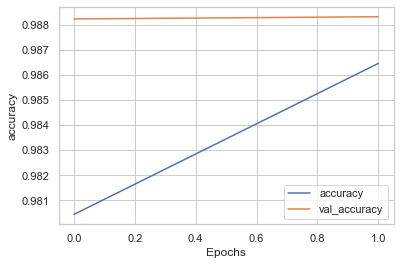

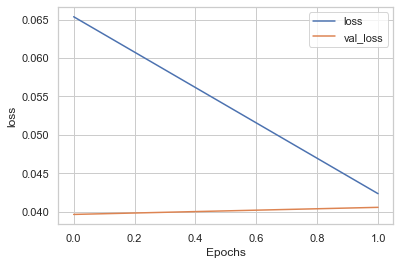

In [106]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

***Initialize***

In [107]:
toxic_label = 1
not_toxic_label = 0
class_num = 2

**F1 function**

In [108]:
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)

**Get offset**

In [109]:
threshold = 0.18 #by user test

text_predictions = model.predict(X_test_prod)

my_pred = []
for i in tqdm(range(len(text_predictions))):
    max_prob = 0
    tmp = []
    for j in range(len(text_predictions[i])):
        #if find class pad, stop    
        if text_predictions[i][j][2]>0.8:
            break
         
        if text_predictions[i][j][1]>threshold:
            tmp.append(1)
        else:
            tmp.append(0)
            
        
    my_pred.append(tmp)
        

In [110]:
df_temp = pd.DataFrame({'pred':my_pred})
df_temp

,pred
0,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
685,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
686,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
687,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]"
688,"[0, 0, 1, 1]"


In [111]:
toxic_offsets_all=[]
for i in range(len(df_dev.token)):
    toxic_offsets = []
    current_offset = 0
    for j in range(len(df_dev.token[i])):
        if df_temp.pred[i][j]==1:
            toxic_offsets.extend(list(range(current_offset, current_offset+len(df_dev.token[i][j]))))
        current_offset += len(df_dev.token[i][j]) + 1
    toxic_offsets_all.append(toxic_offsets)

In [112]:
df_predict = pd.DataFrame({'pred':toxic_offsets_all})
df_predict 

,pred
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31, 32]"
1,"[29, 30, 31, 32, 33, 34, 36, 37, 38]"
2,"[144, 145, 146, 147, 148, 149, 151, 152, 153]"
3,"[87, 88, 89, 90, 91, 92]"
4,"[188, 189, 190, 191, 192, 193, 194, 195, 196, ..."
...,...
685,"[4, 5, 6, 127, 128, 129, 130, 131, 132, 133]"
686,"[124, 125, 126, 127, 128, 129, 130]"
687,"[24, 25, 26, 27, 28, 29, 31, 32, 33]"
688,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 2..."


In [113]:
tsd

,spans,text
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th..."
3,"[87, 88, 89, 90, 91, 92]",Trump Claimed that Russia will never invade th...
4,[],As long as your willing to pay a lot more for ...
...,...,...
685,"[129, 130, 131, 132, 133, 134]",But ... Trump's not bluffing. He's prepared to...
686,"[126, 127, 128, 129, 130, 131]",Can't believe the limited knowledge of this Ar...
687,"[24, 25, 26, 27, 28, 29]",I think it conservative idiots who cannot reac...
688,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",You're an id*ot...Go away.


In [114]:
tsd["predictions"] = df_predict.pred
tsd["f1_scores"] = tsd.apply(lambda row: f1(row.predictions, row.spans), axis=1)

In [115]:
tsd

,spans,text,predictions,f1_scores
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31, 32]",0.952381
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...,"[29, 30, 31, 32, 33, 34, 36, 37, 38]",0.800000
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th...","[144, 145, 146, 147, 148, 149, 151, 152, 153]",0.000000
3,"[87, 88, 89, 90, 91, 92]",Trump Claimed that Russia will never invade th...,"[87, 88, 89, 90, 91, 92]",1.000000
4,[],As long as your willing to pay a lot more for ...,"[188, 189, 190, 191, 192, 193, 194, 195, 196, ...",0.000000
...,...,...,...,...
685,"[129, 130, 131, 132, 133, 134]",But ... Trump's not bluffing. He's prepared to...,"[4, 5, 6, 127, 128, 129, 130, 131, 132, 133]",0.625000
686,"[126, 127, 128, 129, 130, 131]",Can't believe the limited knowledge of this Ar...,"[124, 125, 126, 127, 128, 129, 130]",0.769231
687,"[24, 25, 26, 27, 28, 29]",I think it conservative idiots who cannot reac...,"[24, 25, 26, 27, 28, 29, 31, 32, 33]",0.800000
688,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",You're an id*ot...Go away.,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 2...",0.333333


In [116]:
from scipy.stats import sem
print (f"F1 = {tsd.f1_scores.mean():.2f} ± {sem(tsd.f1_scores):.2f}")

F1 = 0.52 ± 0.01


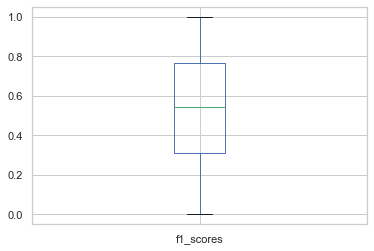

In [117]:
_ = tsd.f1_scores.plot(kind="box")

In [118]:
model.save("model.h5")

## Test set Results

In [119]:
# test data
dataset_test = pd.read_csv("data/tsd_test.csv")

In [120]:
dataset_test

,text
0,That's right. They are not normal. And I am st...
1,"""Watch people die from taking away their healt..."
2,tens years ago i contacted the PDR and suggest...
3,The parallels between the ANC and the Sicilian...
4,Intel Community: ‘How can we work for a Presid...
...,...
1995,hey loser change your name to something more a...
1996,And you are a complete moron who obviously doe...
1997,Such vitriol from the left. Who would have th...
1998,It is now time for most of you to expand your ...


In [121]:
list_doc = [] # is the number of each row in dataset
list_tokens = [] # token of each text

# tranform the dataset as text to token
for text_i in tqdm(range(0,len(dataset_test['text']))):

    list_doc.append(text_i)
        
    # tokenization by space " "
    token = dataset_test.text[text_i].split()
    list_tokens.append(token)

    # add the new list into a dataframe
    df_test_start = pd.DataFrame(list_doc, columns=['doc'])
    df_test_start['token'] = list_tokens

In [122]:
df_test_start

,doc,token
0,0,"[That's, right., They, are, not, normal., And,..."
1,1,"[""Watch, people, die, from, taking, away, thei..."
2,2,"[tens, years, ago, i, contacted, the, PDR, and..."
3,3,"[The, parallels, between, the, ANC, and, the, ..."
4,4,"[Intel, Community:, ‘How, can, we, work, for, ..."
...,...,...
1995,1995,"[hey, loser, change, your, name, to, something..."
1996,1996,"[And, you, are, a, complete, moron, who, obvio..."
1997,1997,"[Such, vitriol, from, the, left., Who, would, ..."
1998,1998,"[It, is, now, time, for, most, of, you, to, ex..."


In [ ]:
#clean dataset code
df_test_start_clean = df_test_start.copy()
for doc in tqdm(range(len(df_test_start_clean.token))):
    temp = pd.DataFrame(df_test_start_clean.token[doc],columns=['token'])
    df_test_start_clean.token[doc] = clean(temp).values.tolist()

In [124]:
df_test_start_clean 

,doc,token
0,0,"[that's, right, they, are, not, normal, and, i..."
1,1,"[watch, people, die, from, taking, away, their..."
2,2,"[tens, years, ago, i, contacted, the, pdr, and..."
3,3,"[the, parallels, between, the, anc, and, the, ..."
4,4,"[intel, community, how, can, we, work, for, a,..."
...,...,...
1995,1995,"[hey, loser, change, your, name, to, something..."
1996,1996,"[and, you, are, a, complete, moron, who, obvio..."
1997,1997,"[such, vitriol, from, the, left, who, would, h..."
1998,1998,"[it, is, now, time, for, most, of, you, to, ex..."


In [125]:
flat,doc_ids = flatten(df_test_start_clean.token) #clean dataset

df_test = pd.DataFrame(flat, columns= ['token'])
df_test['doc'] = doc_ids
df_test

,token,doc
0,that's,0
1,right,0
2,they,0
3,are,0
4,not,0
...,...,...
65717,you're,1999
65718,so,1999
65719,dumb,1999
65720,and,1999


In [126]:
words_test = list(set(df_test["token"].values))
words_test.append("ENDPAD")

In [ ]:
for w in tqdm(words_test):
    if w not in word2idx:
        df_test.token.replace(w,'UNK', inplace=True)
        print(w)

In [128]:
def mySentenceGetter_test(data):
    doc_id = 0
    sentences = []
    temp_doc = []
    for i in tqdm(range(len(data.doc))):
        if data.doc[i]==doc_id :
            temp_doc.append((data["token"][i]))
        else:
            sentences.append(temp_doc)
            doc_id = data.doc[i]
            temp_doc = []
            temp_doc.append((data["token"][i]))
    sentences.append(temp_doc)
    return sentences[1:] 

In [129]:
sentences_test = mySentenceGetter_test(df_test)

In [130]:
X_test = [[word2idx[w] for w in s] for s in sentences_test]

In [131]:
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post",
                  value=n_words - 1)

In [132]:
text_predictions = model.predict(X_test)

my_pred = []
for i in tqdm(range(len(text_predictions))):
    max_prob = 0
    tmp = []
    for j in range(len(text_predictions[i])):
        #if find class pad, stop    
        if text_predictions[i][j][2]>0.8:
            break
            
        if text_predictions[i][j][1]>threshold:
            tmp.append(1)
        else:
            tmp.append(0)
            
        
    my_pred.append(tmp)

In [133]:
df_temp = pd.DataFrame({'pred':my_pred})
df_temp

,pred
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
1995,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1996,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [134]:
toxic_offsets_all=[]
for i in range(len(df_test_start.token)):
    toxic_offsets = []
    current_offset = 0
    for j in range(len(df_test_start.token[i])):
        if df_temp.pred[i][j]==1:
            toxic_offsets.extend(list(range(current_offset, current_offset+len(df_test_start.token[i][j]))))
        current_offset += len(df_test_start.token[i][j]) + 1
    toxic_offsets_all.append(toxic_offsets)

In [135]:
df_predict = pd.DataFrame({'pred':toxic_offsets_all})
df_predict 

,pred
0,"[118, 119, 120, 121, 122, 123, 124, 126, 127, ..."
1,"[53, 54, 55, 56, 58, 59, 60, 61, 63, 64, 65, 6..."
2,"[483, 484, 485, 486, 487, 488, 489, 490, 492, ..."
3,"[47, 48, 49, 50, 51, 413, 414, 415, 416, 417, ..."
4,"[646, 647, 648, 649, 650, 651, 652, 653, 654, ..."
...,...
1995,"[4, 5, 6, 7, 8, 70, 71, 72, 73, 74, 75, 76, 77..."
1996,"[23, 24, 25, 26, 27, 80, 81, 82, 83, 84, 85, 8..."
1997,"[107, 108, 109, 110, 111, 112, 113, 114, 156, ..."
1998,[]


In [136]:
predictions = df_predict.pred.to_list()
ids = df_predict.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("spans-pred.txt", "w") as out:
      for uid, text_scores in zip(ids, predictions):
            out.write(f"{str(uid)}\t{str(text_scores)}\n")

In [137]:
! zip -r random_predictions.zip ./spans-pred.*

updating: spans-pred.txt (164 bytes security) (deflated 84%)


---

# System 2 (with LSTM-CRFs)

In [138]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [139]:
input = Input(shape=(max_len,))
model_crf = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len)(input)  # 20-dim embedding
model_crf = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model_crf)  # variational biLSTM
model_crf = TimeDistributed(Dense(50, activation="relu"))(model_crf)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model_crf)  # output

In [140]:
model_crf = Model(input, out)

In [ ]:
model_crf.compile(optimizer="rmsprop", loss= crf.loss_function,
              metrics=[crf.accuracy])  

In [142]:
# training
history = model_crf.fit(X_train, np.array(y_train), 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.1,
                    verbose=1, 
                    callbacks=[early])

C:\Users\Connalia\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7145 samples, validate on 794 samples
Epoch 1/10
7145/7145 [==============================] - 37s 5ms/step - loss: 0.0935 - crf_viterbi_accuracy: 0.9647 - val_loss: 0.0401 - val_crf_viterbi_accuracy: 0.9870
Epoch 2/10
7145/7145 [==============================] - 35s 5ms/step - loss: 0.0387 - crf_viterbi_accuracy: 0.9860 - val_loss: 0.0306 - val_crf_viterbi_accuracy: 0.9880
Epoch 3/10
7145/7145 [==============================] - 34s 5ms/step - loss: 0.0307 - crf_viterbi_accuracy: 0.9866 - val_loss: 0.0260 - val_crf_viterbi_accuracy: 0.9884
Epoch 4/10
7145/7145 [==============================] - 34s 5ms/step - loss: 0.0248 - crf_viterbi_accuracy: 0.9867 - val_loss: 0.0220 - val_crf_viterbi_accuracy: 0.9881
Epoch 5/10
7145/7145 [==============================] - 37s 5ms/step - loss: 0.0199 - crf_viterbi_accuracy: 0.9868 - val_loss: 0.0179 - val_crf_viterbi_accuracy: 0.9884
Epoch 6/10
7145/7145 [==============================] - 35s 5ms/step - loss: 0.0162 - crf_viterbi_accuracy: 

In [143]:
threshold = 0.18 #by user test

text_predictions = model_crf.predict(X_test_prod)

my_pred = []
for i in tqdm(range(len(text_predictions))):
    max_prob = 0
    tmp = []
    for j in range(len(text_predictions[i])):
        #if find class pad, stop    
        if text_predictions[i][j][2]>0.8:
            break
         
        if text_predictions[i][j][1]>threshold:
            tmp.append(1)
        else:
            tmp.append(0)
            
        
    my_pred.append(tmp)

In [144]:
df_temp = pd.DataFrame({'pred':my_pred})
df_temp

,pred
0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
685,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
686,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
687,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
688,"[0, 0, 0, 0]"


In [145]:
toxic_offsets_all=[]
for i in range(len(df_dev.token)):
    toxic_offsets = []
    current_offset = 0
    for j in range(len(df_dev.token[i])):
        if df_temp.pred[i][j]==1:
            toxic_offsets.extend(list(range(current_offset, current_offset+len(df_dev.token[i][j]))))
        current_offset += len(df_dev.token[i][j]) + 1
    toxic_offsets_all.append(toxic_offsets)

In [146]:
df_predict = pd.DataFrame({'pred':toxic_offsets_all})
df_predict 

,pred
0,"[15, 16, 17, 18, 19]"
1,"[29, 30, 31, 32, 33, 34]"
2,[]
3,"[87, 88, 89, 90, 91, 92]"
4,[]
...,...
685,[]
686,"[124, 125, 126, 127, 128, 129, 130]"
687,"[24, 25, 26, 27, 28, 29]"
688,[]


In [147]:
tsd["predictions_crf"] = df_predict.pred
tsd["f1_scores_crf"] = tsd.apply(lambda row: f1(row.predictions_crf, row.spans), axis=1)

In [148]:
tsd[:25]

,spans,text,predictions,f1_scores,predictions_crf,f1_scores_crf
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31, 32]",0.952381,"[15, 16, 17, 18, 19]",0.666667
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...,"[29, 30, 31, 32, 33, 34, 36, 37, 38]",0.800000,"[29, 30, 31, 32, 33, 34]",1.000000
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th...","[144, 145, 146, 147, 148, 149, 151, 152, 153]",0.000000,[],0.000000
3,"[87, 88, 89, 90, 91, 92]",Trump Claimed that Russia will never invade th...,"[87, 88, 89, 90, 91, 92]",1.000000,"[87, 88, 89, 90, 91, 92]",1.000000
4,[],As long as your willing to pay a lot more for ...,"[188, 189, 190, 191, 192, 193, 194, 195, 196, ...",0.000000,[],1.000000
5,"[8, 9, 10, 11, 12]",Only an idiot would use and believe anything t...,"[8, 9, 10, 11, 12, 85, 86, 87, 88, 89, 90, 91,...",0.222222,"[8, 9, 10, 11, 12]",1.000000
6,"[265, 266, 267, 268, 269, 270, 271, 272, 273, ...",Thanks a lot douchebag. You're the reason the ...,"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 171, ...",0.049231,"[171, 172, 173, 174, 175, 176, 178, 179, 180, ...",0.000000
7,[],kick all the non human criminal illegals out o...,"[0, 1, 2, 3, 17, 18, 19, 20, 21, 23, 24, 25, 2...",0.000000,"[65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76]",0.000000
8,"[38, 39, 40, 41, 42, 43]",Because driving under Ontario laws is stupid e...,"[38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50]",0.666667,"[38, 39, 40, 41, 42, 43]",1.000000
9,"[277, 278, 279, 280, 281, 282, 283, 284, 285, ...",You're wrong. The delay between retirement an...,"[282, 283, 284, 285, 286, 287, 288, 289, 291, ...",0.775510,[],0.000000


In [149]:
from scipy.stats import sem
print (f"F1 = {tsd.f1_scores_crf.mean():.2f} ± {sem(tsd.f1_scores_crf):.2f}")

F1 = 0.41 ± 0.02


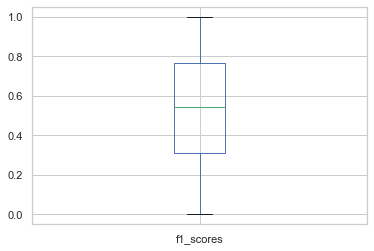

In [150]:
_ = tsd.f1_scores.plot(kind="box")

In [151]:
model_crf.save("model_crf.h5")

**Join Results**

In [152]:
count_crf =0
count=0
for i in range(len(tsd.f1_scores_crf)):

    if tsd.predictions_crf[i]==[]:

        if tsd.f1_scores_crf[i]>=tsd.f1_scores[i]:
            count_crf+=1
        else:
            count+=1
        
print(count_crf)
print(count)

82
196


In [ ]:
tsd["predictions_join"] = df_predict.pred
for i in range(len(tsd["predictions_join"])):
    if tsd.predictions_crf[i]==[] and tsd.predictions[i]==[]:
        tsd["predictions_join"][i]=[]
        next
    if tsd["predictions"][i]==[]:
        tsd["predictions_join"][i]=tsd["predictions_crf"][i]
    if tsd["predictions_crf"][i]==[]:
        tsd["predictions_join"][i]=tsd["predictions"][i]

In [154]:
tsd["f1_scores_join"] = tsd.apply(lambda row: f1(row.predictions_join, row.spans), axis=1)

In [155]:
print (f"F1 = {tsd.f1_scores_join.mean():.2f} ± {sem(tsd.f1_scores_join):.2f}")

F1 = 0.55 ± 0.01


---

# System 3 (with sklearn)
### Libraries

In [156]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from ast import literal_eval

In [157]:
df_train

,token,toxic,doc
0,another,0,0
1,violent,1,0
2,and,1,0
3,aggressive,1,0
4,immigrant,1,0
...,...,...,...
285383,stay,0,7938
285384,out,0,7938
285385,of,0,7938
285386,women's,1,7938


In [158]:
df_develop

,token,toxic,doc
0,because,0,0
1,he's,0,0
2,a,0,0
3,moron,1,0
4,and,0,0
...,...,...,...
24149,prohibited,0,689
24150,reasons,0,689
24151,race,0,689
24152,gender,0,689


***Create one hot dataframe***

In [ ]:
# find toxic words after cleaning text
toxic_words_list = []
nontoxic_words_list = []
for i in tqdm(range(len(df_train.toxic))):
    if df_train.toxic[i]==1:
        toxic_words_list.append(df_train.token[i])
        print(df_train.token[i])
    else:
        nontoxic_words_list.append(df_train.token[i])

In [160]:
len(toxic_words_list)

21433

In [161]:
# put toxic words in dataframe
df_fast_1= pd.DataFrame(toxic_words_list,columns=['token_toxic'])

In [162]:
# transform to one hot
df_fast = pd.get_dummies(df_fast_1.token_toxic)

In [163]:
df_fast

,,#unlearn150,#whitefragilitycankissmyass,#yourwhitetearsarentsacredthislandisc,$#it,%,&,&amp,'cdn,'demonic',...,zones,zoo,~,«,·,»,–,’s,“lying”,…
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
df_y_1 = pd.DataFrame(1, index=np.arange(len(df_fast)),columns= ['toxic'])

In [165]:
df_fast_2 = pd.DataFrame(0, index=np.arange(len(nontoxic_words_list)), columns=list(df_fast.columns))

In [166]:
df_fast_2

,,#unlearn150,#whitefragilitycankissmyass,#yourwhitetearsarentsacredthislandisc,$#it,%,&,&amp,'cdn,'demonic',...,zones,zoo,~,«,·,»,–,’s,“lying”,…
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
df_y_2 = pd.DataFrame(0, index=np.arange(len(df_fast_2)),columns= ['toxic'])

In [168]:
frames = [df_fast, df_fast_2]
df_train_oneHot = pd.concat(frames)

frames = [df_y_1,df_y_2]
df_y = pd.concat(frames)

In [169]:
df_train_oneHot

,,#unlearn150,#whitefragilitycankissmyass,#yourwhitetearsarentsacredthislandisc,$#it,%,&,&amp,'cdn,'demonic',...,zones,zoo,~,«,·,»,–,’s,“lying”,…
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
y = df_y.toxic.values
classes = np.unique(y)
classes = classes.tolist()

In [171]:
X_train = df_train_oneHot
y_train = y

**Models from sklearn**

In [172]:
sgd = SGDClassifier()
sgd.partial_fit(X_train, y_train, classes)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [173]:
nb = MultinomialNB(alpha=0.01)
nb.partial_fit(X_train, y_train, classes)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [174]:
pa =PassiveAggressiveClassifier()
pa.partial_fit(X_train, y_train, classes)

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

**Preprocessing**

In [175]:
words = list(set(df_train["token"].values))
word2idx = {w: i for i, w in enumerate(words)}

words_val = list(set(df_develop["token"].values))

In [176]:
df_develop_old = df_develop.copy()

for w in tqdm(words_val):
    if w not in word2idx:
        df_develop.token.replace(w,'UNK', inplace=True) #georg
#         #find the most similar words for those that are out of vocabulary
#         similar = ft_model.wv.most_similar(positive=[w], topn=1)
#         df_develop.token.replace(w,similar[0][0], inplace=True)

In [177]:
df_develop['temp_toxic']= [0]*len(df_develop.token)
df_develop

,token,toxic,doc,temp_toxic
0,because,0,0,0
1,he's,0,0,0
2,a,0,0,0
3,moron,1,0,0
4,and,0,0,0
...,...,...,...,...
24149,prohibited,0,689,0
24150,reasons,0,689,0
24151,race,0,689,0
24152,gender,0,689,0


In [178]:
for i in tqdm(range(len(df_develop.token))):
    if df_develop.token[i] in toxic_words_list:
         df_develop.temp_toxic[i]=1

C:\Users\Connalia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [179]:
df_dev_fast = pd.DataFrame(0, index=np.arange(len(df_develop.token)), columns=list(df_fast.columns))

In [180]:
for i in tqdm(range(len(df_develop.token))):
    if df_develop.temp_toxic[i]==1:
        df_dev_fast[df_develop.token[i]][i]=1

**Predict for Naive Bayes Classifier**

In [181]:
y_pred=nb.predict(df_dev_fast)

In [182]:
doc_id = 0
sentences = []
temp_doc = []
for i in tqdm(range(len(df_develop.doc))):
    if df_develop.doc[i]==doc_id :
        temp_doc.append(y_pred[i])
    else:
        sentences.append(temp_doc)
        doc_id = df_develop.doc[i]
        temp_doc = []
        temp_doc.append(y_pred[i])
sentences.append(temp_doc)

In [183]:
df_temp = pd.DataFrame({'pred':sentences[1:]})
df_temp

,pred
0,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1]"
1,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, ..."
2,"[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, ..."
3,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, ..."
...,...
685,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, ..."
686,"[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, ..."
687,"[1, 0, 1, 0, 1, 1, 0, 0, 1, 0]"
688,"[0, 0, 0, 0]"


In [184]:
df_dev

,doc,token,span_start,toxic
0,0,"[Because, he's, a, moron, and, a, bigot., It's...","[0, 8, 13, 15, 21, 25, 27, 34, 39, 43, 47, 52,...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,1,"[How, about, we, stop, protecting, idiots, and...","[0, 4, 10, 13, 18, 29, 36, 40, 44, 51, 55, 60,...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[If, people, were, smart,, they, would, Boycot...","[0, 3, 10, 15, 22, 27, 33, 41, 46, 52, 61, 65,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[Trump, Claimed, that, Russia, will, never, in...","[0, 6, 14, 19, 26, 31, 37, 44, 48, 57, 62, 69,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[As, long, as, your, willing, to, pay, a, lot,...","[0, 3, 8, 11, 16, 24, 27, 31, 33, 37, 42, 46, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
685,685,"[But, ..., Trump's, not, bluffing., He's, prep...","[0, 4, 8, 16, 20, 30, 35, 44, 47, 50, 59, 66, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
686,686,"[Can't, believe, the, limited, knowledge, of, ...","[0, 6, 14, 18, 26, 36, 39, 44, 52, 56, 60, 70,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
687,687,"[I, think, it, conservative, idiots, who, cann...","[0, 2, 8, 11, 24, 31, 35, 42, 48, 51]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
688,688,"[You're, an, id*ot...Go, away.]","[0, 7, 10, 21]","[1, 1, 1, 0]"


In [185]:
tsd = pd.read_csv("data/tsd_trial.csv") 
tsd.spans = tsd.spans.apply(literal_eval)
tsd.head(1)

,spans,text
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...


In [186]:
toxic_offsets_all=[]
for i in range(len(df_dev.token)):
    toxic_offsets = []
    current_offset = 0
    for j in range(len(df_dev.token[i])):
        if df_temp.pred[i][j]==1:
            toxic_offsets.extend(list(range(current_offset, current_offset+len(df_dev.token[i][j]))))
        current_offset += len(df_dev.token[i][j]) + 1
    toxic_offsets_all.append(toxic_offsets)

In [187]:
df_predict = pd.DataFrame({'pred':toxic_offsets_all})
df_predict

,pred
0,"[13, 15, 16, 17, 18, 19, 21, 22, 23, 25, 39, 4..."
1,"[29, 30, 31, 32, 33, 34, 36, 37, 38, 67, 68, 7..."
2,"[3, 4, 5, 6, 7, 8, 22, 23, 24, 25, 41, 42, 43,..."
3,"[0, 1, 2, 3, 4, 14, 15, 16, 17, 44, 45, 46, 87..."
4,"[0, 1, 8, 9, 11, 12, 13, 14, 24, 25, 31, 42, 4..."
...,...
685,"[16, 17, 18, 44, 45, 66, 67, 79, 80, 86, 87, 8..."
686,"[14, 15, 16, 36, 37, 39, 40, 41, 42, 52, 53, 5..."
687,"[0, 8, 9, 24, 25, 26, 27, 28, 29, 31, 32, 33, ..."
688,[]


In [188]:
tsd["predictions"] = df_predict.pred
tsd["f1_scores"] = tsd.apply(lambda row: f1(row.predictions, row.spans), axis=1)

In [189]:
from scipy.stats import sem
print (f"F1 = {tsd.f1_scores.mean():.2f} ± {sem(tsd.f1_scores):.2f}")

F1 = 0.23 ± 0.01


**Predict for PassiveAggressive Classifier**

In [190]:
y_pred=pa.predict(df_dev_fast)

In [191]:
doc_id = 0
sentences = []
temp_doc = []
for i in tqdm(range(len(df_develop.doc))):
    if df_develop.doc[i]==doc_id :
        temp_doc.append(y_pred[i])
    else:
        sentences.append(temp_doc)
        doc_id = df_develop.doc[i]
        temp_doc = []
        temp_doc.append(y_pred[i])
sentences.append(temp_doc)
df_temp = pd.DataFrame({'pred':sentences[1:]})

In [192]:
tsd = pd.read_csv("data/tsd_trial.csv") 
tsd.spans = tsd.spans.apply(literal_eval)

toxic_offsets_all=[]
for i in range(len(df_dev.token)):
    toxic_offsets = []
    current_offset = 0
    for j in range(len(df_dev.token[i])):
        if df_temp.pred[i][j]==1:
            toxic_offsets.extend(list(range(current_offset, current_offset+len(df_dev.token[i][j]))))
        current_offset += len(df_dev.token[i][j]) + 1
    toxic_offsets_all.append(toxic_offsets)
df_predict = pd.DataFrame({'pred':toxic_offsets_all})

In [193]:
tsd["predictions"] = df_predict.pred
tsd["f1_scores"] = tsd.apply(lambda row: f1(row.predictions, row.spans), axis=1)
print (f"F1 = {tsd.f1_scores.mean():.2f} ± {sem(tsd.f1_scores):.2f}")

F1 = 0.23 ± 0.01


**Predict for SGD Classifier**

In [194]:
y_pred=sgd.predict(df_dev_fast)

In [195]:
doc_id = 0
sentences = []
temp_doc = []
for i in tqdm(range(len(df_develop.doc))):
    if df_develop.doc[i]==doc_id :
        temp_doc.append(y_pred[i])
    else:
        sentences.append(temp_doc)
        doc_id = df_develop.doc[i]
        temp_doc = []
        temp_doc.append(y_pred[i])
sentences.append(temp_doc)
df_temp = pd.DataFrame({'pred':sentences[1:]})

In [196]:
tsd = pd.read_csv("data/tsd_trial.csv") 
tsd.spans = tsd.spans.apply(literal_eval)

toxic_offsets_all=[]
for i in range(len(df_dev.token)):
    toxic_offsets = []
    current_offset = 0
    for j in range(len(df_dev.token[i])):
        if df_temp.pred[i][j]==1:
            toxic_offsets.extend(list(range(current_offset, current_offset+len(df_dev.token[i][j]))))
        current_offset += len(df_dev.token[i][j]) + 1
    toxic_offsets_all.append(toxic_offsets)
df_predict = pd.DataFrame({'pred':toxic_offsets_all})

In [197]:
tsd["predictions"] = df_predict.pred
tsd["f1_scores"] = tsd.apply(lambda row: f1(row.predictions, row.spans), axis=1)
print (f"F1 = {tsd.f1_scores.mean():.2f} ± {sem(tsd.f1_scores):.2f}")

F1 = 0.25 ± 0.01


---

# System 4 (with spacy)

In [2]:
import nltk
from nltk.corpus import words
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams
from nltk.metrics.distance  import edit_distance

In [3]:
# Datasets Loading

# training data
dataset = pd.read_csv("data/tsd_train.csv")
# development and validation data
tsd = pd.read_csv("data/tsd_trial.csv")

dataset.spans = dataset.spans.apply(literal_eval)
tsd.spans = tsd.spans.apply(literal_eval)

**Toxic words from lexicons**

In [33]:
lex_1 = pd.read_csv("lexicon/base_list_bad_words.csv")

lex_2 = pd.read_csv("lexicon/swearWords.csv").T
lex_2 = lex_2.reset_index()
lex_2 = lex_2.rename(columns={"index": "bad_word"})

lex_3 = pd.read_csv("lexicon/Terms-to-Block.csv")

lex_4 = pd.read_table("lexicon/bad-words.txt", delim_whitespace=True)

In [34]:
#####################
lex_1 = lex_1.apply(lambda x: x.str.replace(';',''))
correct_spellings_1 = set(lex_1.bad_word.tolist())

lex_1.head()

,bad_word
0,anal
1,anus
2,arse
3,ass
4,ass fuck


In [35]:
#####################
correct_spellings_2 = set(lex_2.bad_word.tolist())
lex_2.head()

,bad_word
0,anal
1,anus
2,arse
3,ass
4,ballsack


In [36]:
#####################
lex_3 = lex_3.apply(lambda x: x.str.replace(',',''))
correct_spellings_3 = set(lex_3.bad_word.tolist())
lex_3.head()

,bad_word
0,a55
1,a55hole
2,aeolus
3,ahole
4,anal


In [37]:
#####################
correct_spellings_4 = set(lex_4.bad_word.tolist())
lex_4.head()

,bad_word
0,abbo
1,abo
2,abortion
3,abuse
4,addict


In [4]:
##################### with all lexicons together
lexicon_toxic = pd.read_pickle('lexicon_toxic')
lexicon_toxic
#####################

,bad_word
0,anal
1,anus
2,arse
3,ass
4,ass fuck
...,...
1377,xtc
1379,yankee
1380,yellowman
1381,zigabo


In [5]:
correct_spellings = set(lexicon_toxic.bad_word.tolist())

**Start algorithm**

In [6]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

In [7]:
# Tranform from a format (character list) to other format (word list)
def spans_to_ents(doc, toxic_spans):
    started = False
    left, right, ents = 0, 0, []
    for token in doc:
        if token.pos_ == 'SPACE': continue
        # if the token is in the spans return just the starting-ending offsets
        if toxic_spans.intersection(set(range(token.idx, token.idx + len(token.text)))):
            if not started:        
                left, started = token.idx, True
            right = token.idx + len(token.text)
        # this is activated when "started" is True and we moved on a non-toxic word,
        # so, just return the saved left/right offsets.
        elif started:
            ents.append((left, right, 'TOXIC'))
            started = False
    if started: 
        ents.append((left, right, 'TOXIC'))
    return ents

In [8]:
idx=2342
print(dataset.iloc[idx].text, dataset.iloc[idx].spans)
spans_to_ents(nlp(dataset.iloc[idx].text), set(dataset.iloc[idx].spans))

The suckers will keep supporting them though because that's what suckers do. [4, 5, 6, 7, 8, 9, 10, 65, 66, 67, 68, 69, 70, 71]


[(4, 11, 'TOXIC'), (65, 72, 'TOXIC')]

In [9]:
TRAIN_DATA = []
#create the new dataset,which we use as training dataset
for _, row in tqdm(dataset.iterrows()):
    doc = nlp(row.text)
    ents = spans_to_ents(doc, set(row.spans))
    TRAIN_DATA.append((doc.text, {'entities': ents}))

In [11]:
nlp = spacy.blank('en')

# We have name regognition task, so we need
# new NER pipe with TOXIC entities
ner = nlp.create_pipe("ner")
ner.add_label('TOXIC')

# add the NER pipe as last component 
nlp.add_pipe(ner, last=True)

In [12]:
# exclude some pipes from being updated during training
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

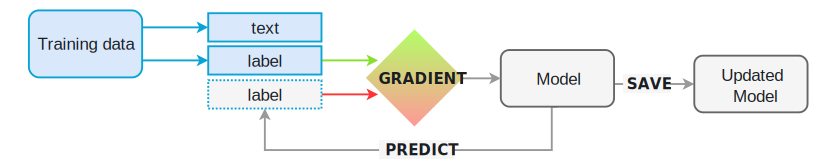

In [13]:
from IPython.display import SVG, display
def show_svg():
    display(SVG(url='https://spacy.io/training-73950e71e6b59678754a87d6cf1481f9.svg'))
    
show_svg()

In [14]:
import random 
with nlp.disable_pipes(*unaffected_pipes):
    
    #start to train
    nlp.begin_training()
    
    # 30 epochs
    for iteration in tqdm(range(34)):
        
        #Shuffle the train dataset.
        random.shuffle(TRAIN_DATA)
        
        losses = {}
        
        #split in to batches
        batches = spacy.util.minibatch(TRAIN_DATA)
        
        #for each batch, update the annotations
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, drop=0.5,  losses=losses)
            
        print("Losses", losses)

Losses {'ner': 33366.638169061}
Losses {'ner': 27556.223101999807}
Losses {'ner': 26586.79743540972}
Losses {'ner': 25286.659407559713}
Losses {'ner': 24674.554992137724}
Losses {'ner': 22745.275418310677}
Losses {'ner': 22358.337486622135}
Losses {'ner': 22622.30854018001}
Losses {'ner': 22453.05603547419}
Losses {'ner': 21743.984888765284}
Losses {'ner': 20284.21718697229}
Losses {'ner': 20653.27579117411}
Losses {'ner': 19962.18084512117}
Losses {'ner': 19349.900276299613}
Losses {'ner': 19223.861453026715}
Losses {'ner': 19319.752207154368}
Losses {'ner': 18825.653725036354}
Losses {'ner': 18763.3373322241}
Losses {'ner': 18512.424420916916}
Losses {'ner': 18287.108121689558}
Losses {'ner': 18385.4364382157}
Losses {'ner': 17571.30212949283}
Losses {'ner': 17816.616516021877}
Losses {'ner': 18301.069329219827}
Losses {'ner': 17708.401236500784}
Losses {'ner': 17287.786448056035}
Losses {'ner': 17675.35899580884}
Losses {'ner': 17247.0664615418}
Losses {'ner': 17422.266667746306}
Lo

#### Result of develop set

In [ ]:
for _, row in tqdm(tsd.iterrows()):
    spacy.displacy.render(nlp(row.text), style='ent', jupyter=True)

In [ ]:
for _, row in tqdm(tsd.iterrows()):
    spacy.displacy.render(nlp(row.text), style='ent', jupyter=True)

In [119]:
toxic_offsets_all=[]
for idx in tqdm(range(len(tsd.spans))):
    toxic_offsets=[]
    for token in nlp(tsd.text[idx]):
        if token.ent_type_=='TOXIC':
            temp = np.arange(token.idx, token.idx + len(token)).tolist()
            toxic_offsets.extend(temp)
            
            
        else:
            token_str= str(token.text).lower()
            if token_str in correct_spellings_1:
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
                print('lex_1---->'+str(token_str))
            elif token_str in correct_spellings_2:
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
                print('lex_2---->'+str(token_str))
            elif token_str in correct_spellings_3:
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
                print('lex_3---->'+str(token_str))
            elif token_str=='g&m':
                trmp = token_str
                # tranform money to TAG (eg 34$ )
                token_str= re.sub('g&m', 'gm', token_str)
            elif token_str=='fukc':
                print(token_str)
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
            elif token_str=='fukcer':
                print(token_str)
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
            elif token_str=='sh__' or token_str=='sh-t' or token_str=='muslims':
                print(token_str)
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
            else:
                trmp = token_str
                # tranform percentage to TAG (eg 34% )
                token_str= re.sub(r'\d+[%]', 'NUM', token_str)
    
                # tranform money to TAG (eg 34$ )
                token_str= re.sub(r'\d+[$]', 'MONEY', token_str)
    
                # tranform money to TAG (eg $34)
                token_str= re.sub(r'[$]\d+', 'MONEY', token_str)
    
                # tranform money to TAG (eg $34)
                token_str= re.sub(r'[$]\w+', 'TOXIC', token_str)
            
                # change hide toxic words (e.g f@@k = f**k)
                token_str= re.sub(r"(\w+[*+$#@&%!]+\w+)", 'TOXIC', token_str)
    
                # change hide toxic words (e.g f***)
                token_str= re.sub(r"(\w+[*$#@&%])", 'TOXIC', token_str)
                
                if token_str=='TOXIC':
                    print(trmp)
                    temp = np.arange(token.idx, token.idx + len(token)).tolist()
                    toxic_offsets.extend(temp)
    toxic_offsets_all.append(toxic_offsets)

lex_3---->wanker
lex_3---->stupid
lex_3---->fucking
lex_3---->assholes
lex_3---->stupid
lex_3---->fucking
lex_3---->assholes
lex_3---->stupid
lex_3---->fucking
lex_1---->asshole
lex_1---->shit
lex_3---->fucks
lex_1---->shit
lex_3---->scum
lex_3---->rapist
a$$hat
lex_3---->meth
lex_3---->weed
lex_3---->meth
lex_3---->sexual
lex_3---->penetration
h*ll
lex_3---->moron
lex_3---->rump
lex_1---->ass
lex_3---->bullshit
muslims
lex_2---->bloody
lex_1---->crap
lex_3---->kill
lex_2---->hell
lex_3---->trashy
f@#k
dumba$$es
lex_3---->virgin
lex_3---->moron
muslims
lex_1---->crap
muslims
lex_1---->fuck
lex_3---->fucking
lex_3---->cunts
lex_2---->balls
lex_1---->fuck
lex_3---->pot
lex_3---->murder
pu**y
lex_3---->weiner
lex_3---->ugly
lex_3---->wanker
lex_3---->ugly
lex_1---->fuck
lex_1---->fuck
muslims
muslims
muslims
lex_3---->screw
lex_3---->beer
lex_3---->drunk
lex_3---->drunk
lex_3---->murder
lex_3---->stupid
lex_3---->nazi
lex_1---->dirty
lex_3---->gays
lex_1---->lesbians
lex_3---->gays
lex_1-

**Predict**

In [120]:
df_predict = pd.DataFrame({'pred':toxic_offsets_all})
df_predict

,pred
0,"[15, 16, 17, 18, 19]"
1,"[29, 30, 31, 32, 33, 34]"
2,"[166, 167, 168, 169, 170, 171]"
3,"[87, 88, 89, 90, 91, 92]"
4,"[188, 189, 190, 191, 192, 193, 194, 195, 196, ..."
...,...
685,"[129, 130, 131, 132, 133, 134]"
686,"[126, 127, 128, 129, 130, 131]"
687,"[24, 25, 26, 27, 28, 29]"
688,"[10, 11, 12, 13, 14]"


In [121]:
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)

In [122]:
tsd["predictions"] = df_predict.pred
tsd["f1_scores"] = tsd.apply(lambda row: f1(row.predictions, row.spans), axis=1)

In [123]:
from scipy.stats import sem
print (f"F1 = {tsd.f1_scores.mean():.2f} ± {sem(tsd.f1_scores):.2f}")

F1 = 0.61 ± 0.02


#### Result of test set

In [124]:
# test data
dataset_test = pd.read_csv("data/tsd_test.csv")

In [ ]:
for _, row in tqdm(dataset_test.iterrows()):
    spacy.displacy.render(nlp(row.text), style='ent', jupyter=True)

In [126]:
toxic_offsets_all=[]
for idx in tqdm(range(len(dataset_test.text))):
    toxic_offsets=[]
    for token in nlp(dataset_test.text[idx]):
        if token.ent_type_=='TOXIC':
            temp = np.arange(token.idx, token.idx + len(token)).tolist()
            toxic_offsets.extend(temp)
            
        else:
            token_str= str(token.text).lower()
            if token_str in correct_spellings_1:
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
                print('lex_1---->'+str(token_str))
            elif token_str in correct_spellings_2:
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
                print('lex_2---->'+str(token_str))
            elif token_str in correct_spellings_3:
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
                print('lex_3---->'+str(token_str))
            elif token_str=='g&m':
                trmp = token_str
                # tranform money to TAG (eg 34$ )
                token_str= re.sub('g&m', 'gm', token_str)
            elif token_str=='fukc':
                print(token_str)
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
            elif token_str=='fukcer':
                print(token_str)
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
            elif token_str=='sh__' or token_str=='sh-t' or token_str=='muslims':
                print(token_str)
                temp = np.arange(token.idx, token.idx + len(token)).tolist()
                toxic_offsets.extend(temp)
            else:
                trmp = token_str
                # tranform percentage to TAG (eg 34% )
                token_str= re.sub(r'\d+[%]', 'NUM', token_str)
    
                # tranform money to TAG (eg 34$ )
                token_str= re.sub(r'\d+[$]', 'MONEY', token_str)
    
                # tranform money to TAG (eg $34)
                token_str= re.sub(r'[$]\d+', 'MONEY', token_str)
    
                # tranform money to TAG (eg $34)
                token_str= re.sub(r'[$]\w+', 'TOXIC', token_str)
            
                # change hide toxic words (e.g f@@k = f**k)
                token_str= re.sub(r"(\w+[*+$#@&%!]+\w+)", 'TOXIC', token_str)
    
                # change hide toxic words (e.g f***)
                token_str= re.sub(r"(\w+[*$#@&%])", 'TOXIC', token_str)
                
                if token_str=='TOXIC':
                    print(trmp)
                    temp = np.arange(token.idx, token.idx + len(token)).tolist()
                    toxic_offsets.extend(temp)
    toxic_offsets_all.append(toxic_offsets)

lex_3---->hitler
lex_3---->nazi
lex_3---->scum
lex_3---->dopey
lex_2---->lmao
lex_2---->bloody
lex_2---->hell
lex_3---->sucked
lex_3---->kill
lex_3---->oral
lex_3---->screw
lex_3---->bang
lex_1---->ass
stu*pid
lex_3---->kill
f*cking
lex_2---->omg
lex_3---->stupid
lex_3---->stupid
lex_3---->stupid
lex_3---->rapist
lex_3---->fat
lex_3---->stupid
lex_1---->crap
lex_3---->sleazy
lex_3---->pubic
lex_3---->sexual
lex_1---->fuck
lex_3---->screwed
lex_3---->sucking
lex_3---->sexual
f**ks
lex_3---->stupid
lex_3---->pot
lex_3---->screwed
lex_3---->thug
lex_3---->sexual
lex_1---->arse
lex_3---->klan
lex_1---->crap
lex_3---->commie
f#ck
lex_3---->screwed
fukc
fukcer
lex_1---->viagra
lex_2---->hell
lex_3---->sexual
lex_3---->sucking
lex_1---->bitch
lex_1---->crap
lex_1---->crap
lex_1---->crap
lex_3---->damned
lex_2---->hell
muslims
lex_3---->kill
muslims
lex_3---->gay
lex_1---->crap
lex_1---->sex
lex_3---->gay
lex_3---->stoned
lex_3---->weed
lex_2---->bloody
lex_3---->drunk
lex_3---->pot
lex_3---->

In [127]:
df_predict = pd.DataFrame({'pred':toxic_offsets_all})
df_predict

,pred
0,"[133, 134, 135, 136, 137, 138, 140, 141, 142, ..."
1,"[81, 82, 83, 84, 85, 86]"
2,"[483, 484, 485, 486, 487, 488, 489, 490]"
3,[]
4,"[141, 142, 143, 144, 145, 146, 271, 272, 273, ..."
...,...
1995,"[4, 5, 6, 7, 8, 70, 71, 72, 73, 74, 75, 76, 77]"
1996,"[23, 24, 25, 26, 27]"
1997,"[157, 158, 159, 160, 161, 162, 163, 164, 165, ..."
1998,[]


In [128]:
predictions = df_predict.pred.to_list()
ids = df_predict.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("spans-pred.txt", "w") as out:
      for uid, text_scores in zip(ids, predictions):
            out.write(f"{str(uid)}\t{str(text_scores)}\n")

In [129]:
! zip -r random_predictions_spacy.zip ./spans-pred.*

updating: spans-pred.txt (164 bytes security) (deflated 81%)
